In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import norm
from root_numpy import root2array
from scipy.optimize import curve_fit
from lmfit import  Model #better gaussian model

In [2]:
#from matplotlib import gridspec
#from matplotlib.colors import LogNorm
#from numpy import polyfit
#from numpy import random

In [3]:
filedir = '/Users/davidkaleko/larlite/UserDev/KalekoAna/scratch_ana/mac/MCS_paper_anafiles/'

anatype = 'singletrack_data' #singlemu_recotracks, singletrack_data, singlemu_mctracks


In [4]:
titles = { 
           'singlemu_mctracks'   : 'Fully Contained Single Muon MCTracks',
           'singlemu_recotracks' : 'Fully Contained, Well Reconstructed Single Muon Tracks',
           'singletrack_data'    : 'Selected, Well Reconstructed Muon Tracks from NumuCC Data',
           'full_range_energy'   : 'Range-Based Total Energy [GeV]',
           'full_MCS_energy'     : 'MCS Total Energy [GeV]',
           'true_E'              : 'True Total Energy [GeV]'
         }

latextitles = {
           'full_range_energy'   : 'E_{Range}',
           'full_MCS_energy'     : 'E_{MCS}',
           'true_E'              : 'E_{True}'
         }

In [5]:
df_dict, segdf_dict = {}, {}
seglens = [ 5, 10, 20, 25 ]
for seglen in seglens:
    myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters.root' %( anatype, seglen )
    #This df has track-by-track information (MCS energy, range energy, etc)
    df_dict[seglen] = pd.DataFrame( root2array ( filedir + myfile, 'MCS_bias_tree' ) )

    #This df has segment-by-segment deviation (scattering angle, etc)
    segdf_dict[seglen] = pd.DataFrame( root2array ( filedir + myfile, 'TMC_debug_tree' ) )
    segdf_dict[seglen]['dthetayoverpredictedRMS'] = segdf_dict[seglen]['delta_theta_y']/segdf_dict[seglen]['predicted_RMS']
    segdf_dict[seglen]['dthetayovertruepredictedRMS'] = segdf_dict[seglen]['delta_theta_y']/segdf_dict[seglen]['true_predicted_RMS']
    segdf_dict[seglen]['dthetayoverpredictedRMS_fromMCS'] = segdf_dict[seglen]['delta_theta_y']/segdf_dict[seglen]['predicted_RMS_fromMCS']
    
    segdf_dict[seglen]['dthetaxoverpredictedRMS'] = segdf_dict[seglen]['delta_theta_x']/segdf_dict[seglen]['predicted_RMS']
    segdf_dict[seglen]['dthetaxovertruepredictedRMS'] = segdf_dict[seglen]['delta_theta_x']/segdf_dict[seglen]['true_predicted_RMS']
    segdf_dict[seglen]['dthetaxoverpredictedRMS_fromMCS'] = segdf_dict[seglen]['delta_theta_x']/segdf_dict[seglen]['predicted_RMS_fromMCS']


In [6]:
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(np.sqrt(2*np.pi)*wid)) * np.exp(-(x-cen)**2 /(2*wid**2))

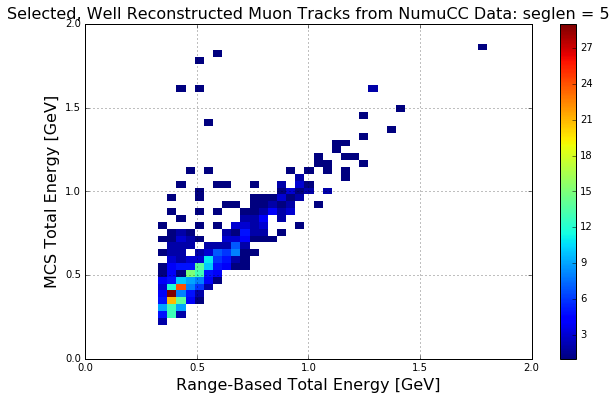

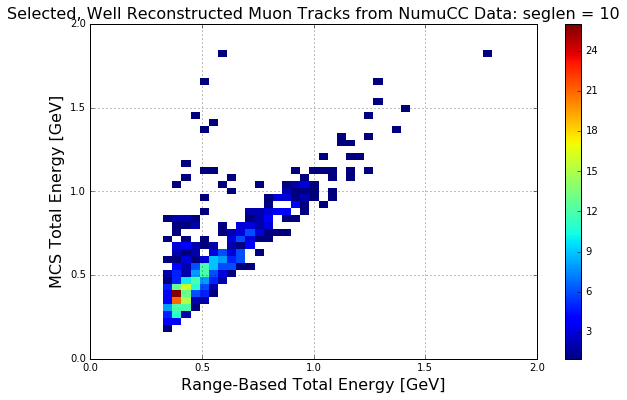

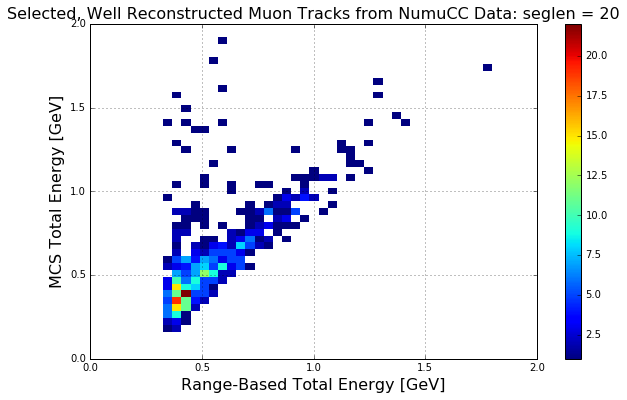

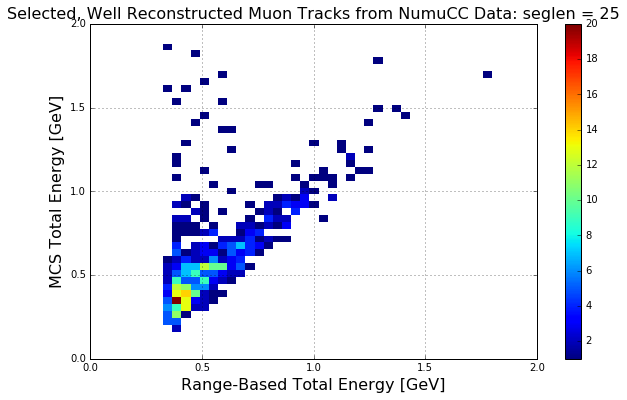

In [7]:
for seglen in seglens:
    plt.figure(figsize=(10,6))
    myx = df_dict[seglen]['full_range_energy'].values
    myy = df_dict[seglen]['full_MCS_energy'].values
    blah = plt.hist2d(myx,myy,bins=((np.linspace(0,2,50),np.linspace(0,2,50))),cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('Range-Based Total Energy [GeV]',fontsize=16)
    blha = plt.ylabel('MCS Total Energy [GeV]',fontsize=16)
    blha = plt.title('%s: seglen = %s'%(titles[anatype],seglen),fontsize=16)

In [8]:
#Read in handscan info if working with data
if anatype == 'singletrack_data':
    filedir = '/Users/davidkaleko/Desktop/'
    myfile = 'handscan_results_kaleko.csv'
    
    hsdf = pd.read_csv(filedir + myfile,index_col=False)
       
    #Column names with spaces are hard to deal with, this is easy
    cols = hsdf.columns
    cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
    hsdf.columns = cols
    
    #If no optional comments were typed in it shows up as NaN
    #Let's just make a column of "optional comments present" (boolean)
    
    hsdf['comments_present'] = hsdf['optional_comments'].notnull()
    
    #Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
    hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0
    
    #maybe bad is either definitely_bad, or if comments are present (more conservative)
    hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']
    
    print "total length of hsdf is",len(hsdf)
    print "number of definitely bad is",len(hsdf.query('definitely_bad'))
    print "number of maybe bad is",len(hsdf.query('maybe_bad'))
    
    #let's rename run, subrun, eventid columns to match the MCS df
    #for now just make a new column because it's easier
    hsdf['run'] = hsdf['Run']
    hsdf['subrun'] = hsdf['Subrun']
    hsdf['eventid'] = hsdf['Event_ID']
    
    for seglen in seglens:
        df_dict[seglen] = df_dict[seglen].merge(hsdf, on=['run','subrun','eventid'])

        segdf_dict[seglen] = segdf_dict[seglen].merge(hsdf, on=['run','subrun','eventid'])

total length of hsdf is 619
number of definitely bad is 118
number of maybe bad is 212


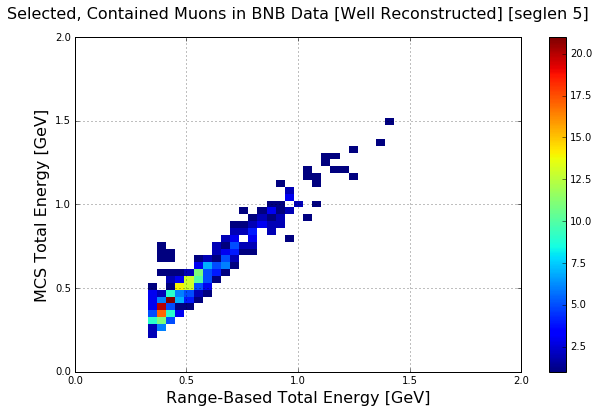

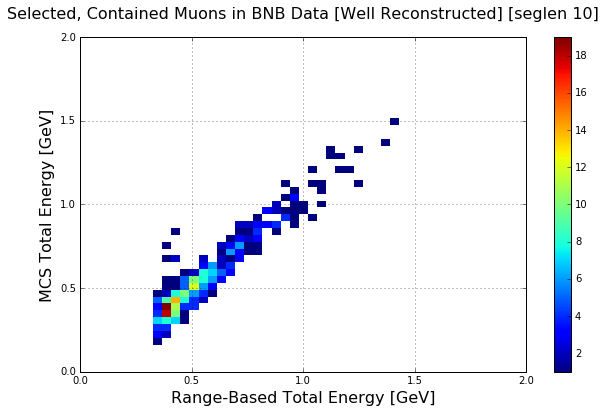

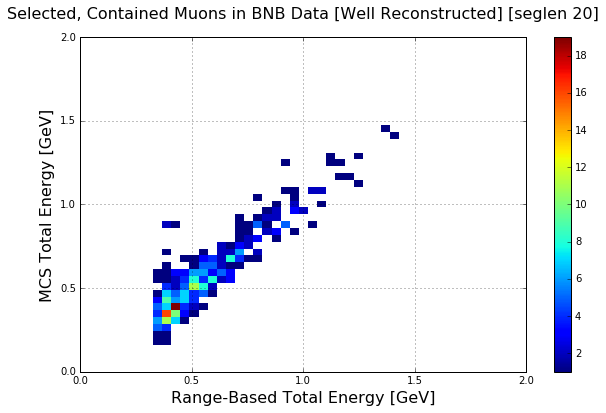

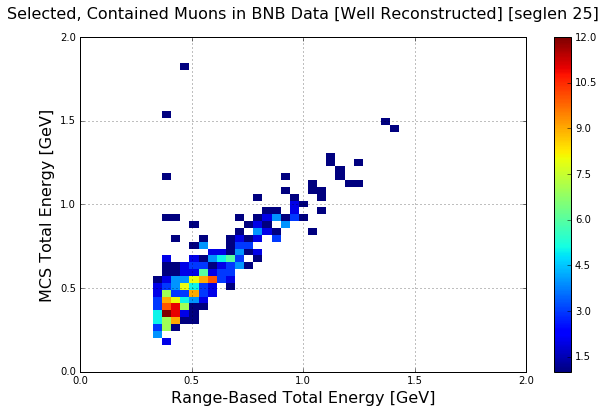

In [9]:
for seglen in seglens:
    mybins = (np.linspace(0,2,50),np.linspace(0,2,50))    
    myquery = 'not maybe_bad'
    plt.figure(figsize=(10,6))
    myx = df_dict[seglen].query(myquery)['full_range_energy'].values
    myy = df_dict[seglen].query(myquery)['full_MCS_energy'].values
    blah = plt.hist2d(myx,myy,bins=mybins,cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('Range-Based Total Energy [GeV]',fontsize=16)
    blha = plt.ylabel('MCS Total Energy [GeV]',fontsize=16)
    blha = plt.title('Selected, Contained Muons in BNB Data [Well Reconstructed] [seglen %s]'%seglen,fontsize=16)
    blha.set_y(1.04)
    #blah = plt.plot([0,100],[0,100],'g--',linewidth=5)


In [10]:
def highlandE(rms):
    loverX = float(seglen)/14.
    return np.sqrt((13.6*13.6*loverX*np.square((1+0.038*np.log(loverX))))/np.square(rms))

In [11]:
def deflection_plot(segdf,binmin,binmax,nbins,extraquery=None):
    
    fig = plt.figure(figsize=(10,6))
    
    poop = plt.grid(True)
    
    myquery = 'run < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery

    mybins = np.linspace(binmin,binmax,nbins)
    
    myvar1 = 'dthetayoverpredictedRMS_fromMCS'
    myvar2 = 'dthetaxoverpredictedRMS_fromMCS'

    myvals = np.append(
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar1,binmin,myvar1,binmax))[myvar1].values,
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar2,binmin,myvar2,binmax))[myvar2].values
    )
        
    mystd = np.std(myvals)
    mymean = np.mean(myvals)

    datahist = plt.hist(myvals,bins=mybins,normed=True,
                             alpha=0.5,label='$\Delta\\theta/RMS$ Values')#,
                            #weights = myweights)
   
    datahist_nonorm = np.histogram(myvals,bins=mybins,normed=False)
    
    binvals = datahist[0]
    bincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
    # Fit a normal distribution
    gmod = Model(gaussian)
    #initial random guesses of 1, 1, 2
    result = gmod.fit(binvals, x=bincenters, amp=1, cen=1, wid=2)

    #print(result.fit_report())
    #print help(result)
    #plt.plot(bincenters, binvals,         'bo')
    #plt.plot(bincenters, result.init_fit, 'k--')
    print result.params
    plt.plot(bincenters, result.best_fit, 'g-',\
             label='Gaussian Fit: $\sigma$ = %0.2f' % result.params['wid'],\
            linewidth=4)
  
    #data_mu, data_std = norm.fit(myvals)
    
    #myhighland = highlandE(data_std)

    # Plot the PDF.
    #x = np.linspace(binmin,binmax,100)
    #p = norm.pdf(x, data_mu, data_std)
    #plt.plot(x, p, 'g', linewidth=4,label='Gaussian Fit to Data')
    
    
    plt.title('%s'%titles[anatype],fontsize=14)
   
    plt.xlabel('Delta Theta / RMS',fontsize=16)
    blah = plt.legend(loc='best')
    leg = plt.legend(loc=2)

Parameters([('amp', <Parameter 'amp', value=0.78015152237172414 +/- 0.057, bounds=[-inf:inf]>), ('cen', <Parameter 'cen', value=-0.0016360655419113083 +/- 0.0364, bounds=[-inf:inf]>), ('wid', <Parameter 'wid', value=0.43071455743683318 +/- 0.0364, bounds=[-inf:inf]>)])
Parameters([('amp', <Parameter 'amp', value=0.958590058976591 +/- 0.0153, bounds=[-inf:inf]>), ('cen', <Parameter 'cen', value=-0.0073415040317288908 +/- 0.016, bounds=[-inf:inf]>), ('wid', <Parameter 'wid', value=0.86879711558798833 +/- 0.016, bounds=[-inf:inf]>)])
Parameters([('amp', <Parameter 'amp', value=0.99613698417068486 +/- 0.0106, bounds=[-inf:inf]>), ('cen', <Parameter 'cen', value=-0.002784615868199542 +/- 0.013, bounds=[-inf:inf]>), ('wid', <Parameter 'wid', value=1.0555315874049436 +/- 0.013, bounds=[-inf:inf]>)])
Parameters([('amp', <Parameter 'amp', value=1.0057921795185172 +/- 0.0102, bounds=[-inf:inf]>), ('cen', <Parameter 'cen', value=0.00053201361014880248 +/- 0.0129, bounds=[-inf:inf]>), ('wid', <Par

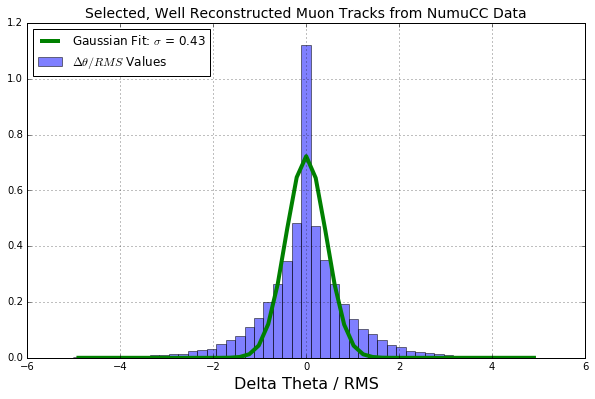

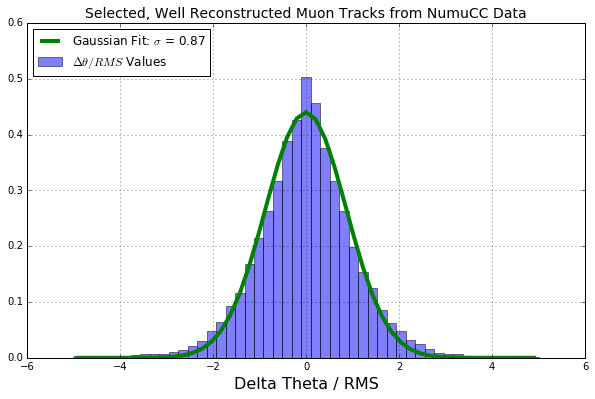

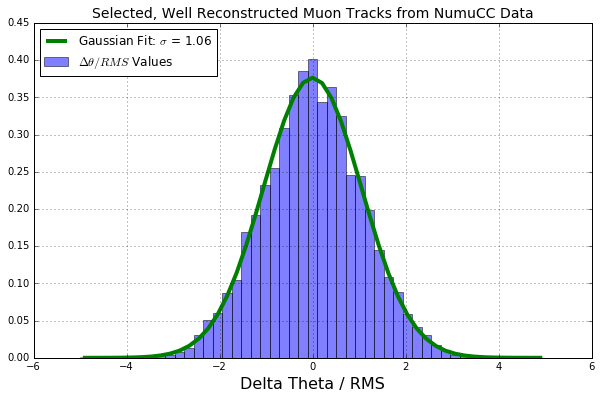

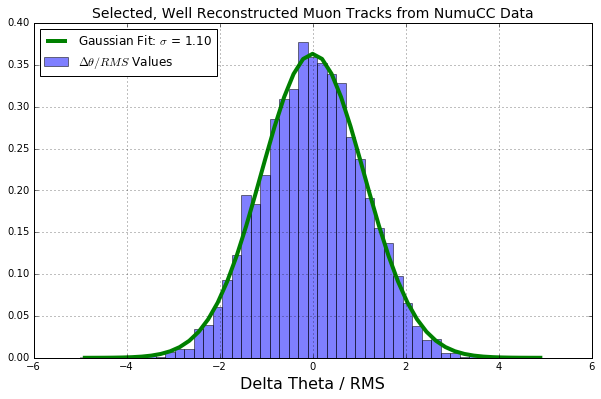

In [12]:
for seglen in seglens:
    dummy = deflection_plot(segdf_dict[seglen],-5,5,50,extraquery='not maybe_bad')

In [13]:
#reco-true/true
def fractional_bias_plots(xvar = 'full_range_energy', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_energy', plot_bin_distributions = False):

    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    
    for seglen in seglens:
      
        myreses, mystds, myerrs = [], [], []
    
        for x in xrange(len(binning)-1):
            binmin = binning[x]
            binmax = binning[x+1]
            
            myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)
            if anatype == 'singletrack_data': 
                myquery += 'and not maybe_bad'
                
            mydf = df_dict[seglen].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            myerr = mystd / np.sqrt( float(len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs.append( myerr )
            
    #         if plot_bin_distributions:
    #             plt.figure(figsize=(5,3))
    #             mybins = np.linspace(-.8,.8,20)
    #             plt.hist((reco-true)/true,color='r',alpha=0.5,label='%d Entries'%len((reco-true)/true),\
    #                      bins=mybins)
    #             titlestring = '$\\frac{%s - %s}{%s}$ for $%s$ in %0.2f $\\rightarrow$ %0.2f GeV'% \
    #             (latextitles[yvar],latextitles[xvar],latextitles[xvar],latextitles[xvar],binmin,binmax)
    #             t =plt.title(titlestring,fontsize=16)
    #             #move the title up a bit
    #             t.set_y(1.04) 
    #             plt.grid(True)
                
    #             plt.xlabel('$\\frac{%s - %s}{%s}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=16)
    #             plt.ylabel('Counts',fontsize=16)
    #             plt.xlim((-0.8,0.8))
    #             plt.legend(loc=1)
                
        
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs,fmt='o--',label='Mean of Distribution, Errors = std/sqrt(N). Seglen %s'%seglen)
    plt.ylabel('mean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias: %s'%titles[anatype],fontsize=16)
    t.set_y(1.04) 


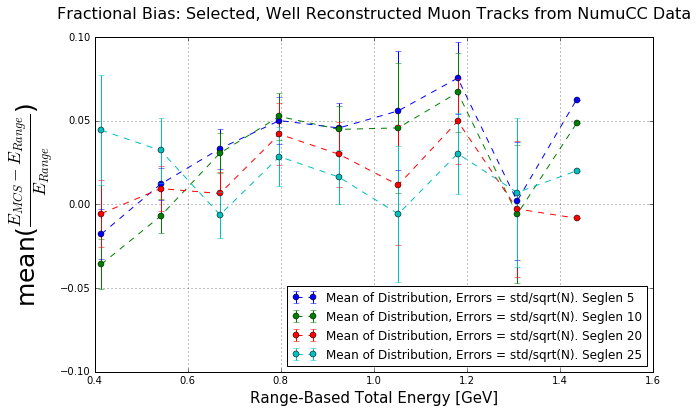

In [14]:
#fractional_bias_plot()
#blah = plt.ylim((-.2,.2))
#fractional_bias_plot(xvar='true_E',yvar='full_range_energy',xbins=np.linspace(0.35,2,10),
#                    plot_bin_distributions = True)
#blah = plt.ylim((-.05,.05))

fractional_bias_plots(xvar='full_range_energy',xbins=np.linspace(0.35,1.5,10),
                    plot_bin_distributions = False)
blah = plt.ylim((-.1,.1))


In [15]:

#Here I fit the resolution to a realistic resolution equation
def res_eqtn(E,a,b,c):
    return np.sqrt(np.square(a/np.sqrt(E)) + np.square(b/E) + np.square(c))

#def res_eqtn(x,a):
#    return a/np.sqrt(x)

#def res_eqtn(E,a,b,c):
#    return np.sqrt(np.square(a/np.sqrt(1./E)) + np.square(b/(1./E)) + np.square(c))


#reco-true/true
def resolution_plots(xvar = 'full_range_energy', xbins = np.linspace(0.35,1,10), draw_fit = True,
                   yvar = 'full_MCS_energy'):
   
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    
    for seglen in seglens:
        if seglen == 15: continue
        
        myreses, mystds, myerrs = [], [], []
        myN = []
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)
            if anatype == 'singletrack_data':
                myquery += ' and not maybe_bad'
            mydf = df_dict[seglen].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            #Error of standard deviation is sigma/sqrt(2N)
            myerr = mystd / np.sqrt( 2 * float(len(true)) )
            myN.append(len(true))
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs.append( myerr )
                
        
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs,fmt='o--',label='Std of Distribution, Errors = std/sqrt(2N). Seglen %s'%seglen)
        plt.ylabel('std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
        plt.xlabel('%s'%titles[xvar],fontsize=15)
        plt.grid(True)
        t = plt.title('Energy Resolution: %s' % titles[anatype],fontsize=16)
        #move the title up a bit
        t.set_y(1.04) 
        
        plt.legend(loc='best')

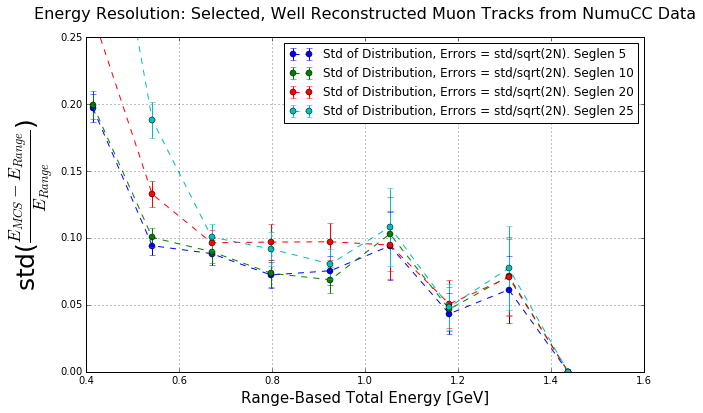

In [16]:
#first, second = resolution_plot(xvar='true_E',draw_fit=False,yvar='full_range_energy',
#                                xbins=np.linspace(0.35,2,10))
#blah = plt.ylim((0,0.05))
#first, second = resolution_plot(xvar='true_E',draw_fit=False)
#blah = plt.ylim((0,0.4))
resolution_plots(xvar='full_range_energy',draw_fit=False,xbins=np.linspace(0.35,1.5,10))
blah = plt.ylim((0,0.25))
